<a href="https://colab.research.google.com/github/alteush/Deep-Learning-2024/blob/main/PS3_Attention_Please_2024_ID_310320650.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Machine Translation with Attention

Advanced Learning Fall 2024.   
Last updated: 2025-01-12


For SUBMISSION:   

Please upload the complete and executed `ipynb` to your git repository. Verify that all of your output can be viewed directly from github, and provide a link to that git file below.

~~~
STUDENT ID: 310320650
~~~

~~~
STUDENT GIT LINK: https://github.com/alteush/Deep-Learning-2024/tree/main/Problem%20Set%203
~~~
In Addition, don't forget to add your ID to the files, and upload to moodle the html version:    
  
`PS3_Attention_2024_ID_310320650.html`   




In this problem set we are going to jump into the depths of `seq2seq` and `attention` and build a couple of PyTorch translation mechanisms with some  twists.     


*   Part 1 consists of a somewhat unorthodox `seq2seq` model for simple arithmetics
*   Part 2 consists of an `seq2seq - attention` language translation model. We will use it for Hebrew and English.  


---

A **seq2seq** model (sequence-to-sequence model) is a type of neural network designed specifically to handle sequences of data. The model converts input sequences into other sequences of data. This makes them particularly useful for tasks involving language, where the input and output are naturally sequences of words.

Here's a breakdown of how `seq2seq` models work:

* The encoder takes the input sequence, like a sentence in English, and processes it to capture its meaning and context.

* information is then passed to the decoder, which uses it to generate the output sequence, like a translation in French.

* Attention mechanism (optional): Some `seq2seq` models also incorporate an attention mechanism. This allows the decoder to focus on specific parts of the input sequence that are most relevant to generating the next element in the output sequence.

`seq2seq` models are used in many natural language processing (NLP) tasks.



imports: (feel free to add)

In [ ]:
%matplotlib inline

In [ ]:
# from __future__ import unicode_literals, print_function, division
# from io import open
# import unicodedata
import re
import random
import unicodedata

import time
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Part 1: Seq2Seq Arithmetic model

**Using RNN `seq2seq` model to "learn" simple arithmetics!**

> Given the string "54-7", the model should return a prediction: "47".  
> Given the string "10+20", the model should return a prediction: "30".


- Watch Lukas Biewald's short [video](https://youtu.be/MqugtGD605k?si=rAH34ZTJyYDj-XJ1) explaining `seq2seq` models and his toy application (somewhat outdated).
- You can find the code for his example [here](https://github.com/lukas/ml-class/blob/master/videos/seq2seq/train.py).    



1.1) Using Lukas' code, implement a `seq2seq` network that can learn how to solve **addition AND substraction** of two numbers of maximum length of 4, using the following steps (similar to the example):      

* Generate data; X: queries (two numbers), and Y: answers   
* One-hot encode X and Y,
* Build a `seq2seq` network (with LSTM, RepeatVector, and TimeDistributed layers)
* Train the model.
* While training, sample from the validation set at random so we can visualize the generated solutions against the true solutions.    

Notes:  
* The code in the example is quite old and based on Keras. You might have to adapt some of the code to overcome methods/code that is not supported anymore. Hint: for the evaluation part, review the type and format of the "correct" output - this will help you fix the unsupported "model.predict_classes".
* Please use the parameters in the code cell below to train the model.     
* Instead of using a `wandb.config` object, please use a simple dictionary instead.   
* You don't need to run the model for more than 50 iterations (epochs) to get a gist of what is happening and what the algorithm is doing.
* Extra credit if you can implement the network in PyTorch (this is not difficult).    
* Extra credit if you are able to significantly improve the model.

ANSWER

See implementation below.

1.2).

a) Do you think this model performs well?  Why or why not?     
b) What are its limitations?   
c) What would you do to improve it?    
d) Can you apply an attention mechanism to this model? Why or why not?   

ANSWER

a) It seems the model is performing well, given its accuracy and digit accuracy scores.

b) The first limitation is that it's contrained to four digits. The 2nd limitation is that thwer's no error bound. Contrary to a human who might miscalculate but will return a number, the model might return "--++4".

c) I thought to add a constraint to produce either a sequence of digits or a sequence starting with "-". Plus, I'd add that "0" can't be the first digit if the number has more than one digit.

d) An Attention mechanism can be applied to the model. See implementation below.

1.3).  

Add attention to the model. Evaluate the performance against the `seq2seq` you trained above. Which one is performing better?

1.4)

Using any neural network architecture of your liking, build  a model with the aim to beat the best performing model in 1.1 or 1.3. Compare your results in a meaningful way, and add a short explanation to why you think/thought your suggested network is better.

In [ ]:
config = {}
config["training_size"] = 40000
config["digits"] = 4
config["hidden_size"] = 128
config["batch_size"] = 128
config["iterations"] = 50
chars = '0123456789-+ '

SOLUTION:

In [ ]:
# adapted from https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, RepeatVector, Dense


class CharacterTable(object):
    """Given a set of characters:
    + Encode them to a one hot integer representation
    + Decode the one hot integer representation to their character output
    + Decode a vector of probabilities to their character output
    """
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One hot encode given string C.
        # Arguments
            num_rows: Number of rows in the returned one hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)

# Maximum length of input is 'int + int' (e.g., '345+678'). Maximum length of
# int is DIGITS.
maxlen = config["digits"] + 1 + config["digits"]

# All the numbers, plus sign and space for padding.
chars = '0123456789+- '
ctable = CharacterTable(chars)

questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < config["training_size"]:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, config["digits"] + 1))))
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = '{}-{}'.format(a, b)
    query = q + ' ' * (maxlen - len(q))
    ans = str(a - b)
    # Answers can be of maximum size DIGITS + 1.
    ans += ' ' * (config["digits"] + 1 - len(ans))

    questions.append(query)
    expected.append(ans)

print('Total addition questions:', len(questions))

print('Vectorization...')
x = np.zeros((len(questions), maxlen, len(chars)), dtype=bool)
y = np.zeros((len(questions), config["digits"] + 1, len(chars)), dtype=bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, maxlen)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, config["digits"] + 1)

# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

model = Sequential()
model.add(LSTM(config["hidden_size"], input_shape=(maxlen, len(chars))))
model.add(RepeatVector(config["digits"] + 1))
model.add(LSTM(config["hidden_size"], return_sequences=True))
model.add(TimeDistributed(Dense(len(chars), activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

# Train the model each generation and show predictions against the validation
# dataset.
for iteration in range(1, config["iterations"]):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(x_train, y_train,
              batch_size=config["batch_size"],
              epochs=1,
              validation_data=(x_val, y_val))
#              validation_data=(x_val, y_val),callbacks=[WandbCallback()])
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        predict_x=model.predict(rowx)
        preds=np.argmax(predict_x[0],axis=1)
#        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds, calc_argmax=False)
        print('Q', q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print('☑', end=' ')
        else:
            print('☒', end=' ')
        print(guess)

Generating data...
Total addition questions: 40000
Vectorization...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          72,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 5, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 5, 128)              │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 5, 13)               │           1,677 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 205,965 (804.55 KB)

 Trainable params: 205,965 (804.55 KB)

 Non-trainable params: 0 (0.00 B)


--------------------------------------------------
Iteration 1
282/282 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.2872 - loss: 2.1066 - val_accuracy: 0.4083 - val_loss: 1.6250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
Q 40-875    T -835  ☒ -779 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Q 532-90    T 442   ☒ 233  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Q 221-26    T 195   ☒ 111  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Q 864-7646  T -6782 ☒ -6666
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Q 7670-34   T 7636  ☒ 6666 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Q 840-98    T 742   ☒ 18   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Q 4-754     T -750  ☒ -443 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Q 5119-5623 T -504  ☒ -313 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Q 65-2483   T -2418 ☒ -5333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Q 5598-56   T 5542  ☒ 566  

--------------------------------------------------
Iteration 2
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4178 - loss: 1.5962 - val_accuracy: 0.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Attention
from tensorflow.keras.utils import to_categorical

# Define parameters
char_to_idx = {c: i for i, c in enumerate(chars)}
idx_to_char = {i: c for c, i in char_to_idx.items()}

# Build Seq2Seq Model with Attention

encoder_inputs = Input(shape=(maxlen, len(chars)))
encoder_lstm = LSTM(config["hidden_size"], return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

decoder_inputs = RepeatVector(config["digits"] + 1)(state_h)
decoder_lstm = LSTM(config["hidden_size"], return_sequences=True)(decoder_inputs)

attention = Attention()([decoder_lstm, encoder_outputs])
decoder_combined = tf.keras.layers.Concatenate()([decoder_lstm, attention])

decoder_dense = TimeDistributed(Dense(len(chars), activation='softmax'))
decoder_outputs = decoder_dense(decoder_combined)

model = Model(encoder_inputs, decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using existing datasets
model.fit(x_train, y_train, batch_size=config["batch_size"],\
          epochs=config["iterations"], validation_data=(x_val, y_val))

# Function to decode predictions
def decode_sequence(input_seq):
    prediction = model.predict(input_seq)
    pred_idx = np.argmax(prediction, axis=-1)
    return ''.join(idx_to_char[idx] for idx in pred_idx[0]).strip()

Epoch 1/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.3039 - loss: 2.0875 - val_accuracy: 0.4221 - val_loss: 1.6410
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.4341 - loss: 1.5959 - val_accuracy: 0.4414 - val_loss: 1.5521
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4484 - loss: 1.5315 - val_accuracy: 0.4462 - val_loss: 1.5015
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4566 - loss: 1.4864 - val_accuracy: 0.4572 - val_loss: 1.4842
Epoch 5/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4706 - loss: 1.4317 - val_accuracy: 0.4770 - val_loss: 1.3949
Epoch 6/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4872 - loss: 1.3802 - val_accuracy: 0.4959 - val_loss: 1.3578
Epoch 7/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5112 - loss: 1.3147 - val_accuracy: 0.5248 - val_loss: 1.2762
Epoch 8/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5351 - loss: 1.2544 - val_accuracy: 0

---

## Part 2: A language translation model with attention

In this part of the problem set we are going to implement a translation with a Sequence to Sequence Network and Attention model.

0) Please go over the NLP From Scratch: Translation with a Sequence to Sequence Network and Attention [tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html). This attention model is very similar to what was learned in class (Luong), but a bit different. What are the main differences between  Badahnau and Luong attention mechanisms?    



1.a) Using `!wget`, `!unzip` , download and extract the [hebrew-english](https://www.manythings.org/anki/) sentence pairs text file to the Colab `content/`  folder (or local folder if not using Colab).
1.b) The `heb.txt` must be parsed and cleaned (see tutorial for requirements or change the code as you see fit).   


2.a) Use the tutorial example to build  and train a Hebrew to English translation model with attention (using the parameters in the code cell below). Apply the same `eng_prefixes` filter to limit the train/test data.   
2.b) Evaluate your trained model randomly on 20 sentences.  
2.c) Show the attention plot for 5 random sentences.  


ANSWER

See implementation below.

3) Do you think this model performs well? Why or why not? What are its limitations/disadvantages? What would you do to improve it?  


ANSWER

The model seems to perform well given its accuracy rates.

4) Using any neural network architecture of your liking, build  a model with the aim to beat the model in 2.a. Compare your results in a meaningful way, and add a short explanation to why you think/thought your suggested network is better.

In [ ]:
# use the following parameters:
MAX_LENGTH = 10
hidden_size = 128
epochs = 50

SOLUTION:

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#!unzip "/content/drive/MyDrive/Statistics Masters/Adv. computational learning and data analysis/Problem Set 3/heb-eng.zip" -d \
#"/content/drive/MyDrive/Statistics Masters/Adv. computational learning and data analysis/Problem Set 3/"

In [ ]:
# -*- coding: utf-8 -*-
"""
NLP From Scratch: Translation with a Sequence to Sequence Network and Attention
*******************************************************************************
**Author**: `Sean Robertson <https://github.com/spro>`_

This tutorials is part of a three-part series:

* `NLP From Scratch: Classifying Names with a Character-Level RNN <https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html>`__
* `NLP From Scratch: Generating Names with a Character-Level RNN <https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html>`__
* `NLP From Scratch: Translation with a Sequence to Sequence Network and Attention <https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html>`__

This is the third and final tutorial on doing **NLP From Scratch**, where we
write our own classes and functions to preprocess the data to do our NLP
modeling tasks.

In this project we will be teaching a neural network to translate from
French to English.

.. code-block:: sh

    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

... to varying degrees of success.

This is made possible by the simple but powerful idea of the `sequence
to sequence network <https://arxiv.org/abs/1409.3215>`__, in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

To improve upon this model we'll use an `attention
mechanism <https://arxiv.org/abs/1409.0473>`__, which lets the decoder
learn to focus over a specific range of the input sequence.

**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  https://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user


It would also be useful to know about Sequence to Sequence networks and
how they work:

-  `Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation <https://arxiv.org/abs/1406.1078>`__
-  `Sequence to Sequence Learning with Neural
   Networks <https://arxiv.org/abs/1409.3215>`__
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`__
-  `A Neural Conversational Model <https://arxiv.org/abs/1506.05869>`__

You will also find the previous tutorials on
:doc:`/intermediate/char_rnn_classification_tutorial`
and :doc:`/intermediate/char_rnn_generation_tutorial`
helpful as those concepts are very similar to the Encoder and Decoder
models, respectively.

**Requirements**
"""
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

######################################################################
# Loading data files
# ==================
#
# The data for this project is a set of many thousands of English to
# French translation pairs.
#
# `This question on Open Data Stack
# Exchange <https://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages>`__
# pointed me to the open translation site https://tatoeba.org/ which has
# downloads available at https://tatoeba.org/eng/downloads - and better
# yet, someone did the extra work of splitting language pairs into
# individual text files here: https://www.manythings.org/anki/
#
# The English to French pairs are too big to include in the repository, so
# download to ``data/eng-fra.txt`` before continuing. The file is a tab
# separated list of translation pairs:
#
# .. code-block:: sh
#
#     I am cold.    J'ai froid.
#
# .. note::
#    Download the data from
#    `here <https://download.pytorch.org/tutorial/data.zip>`_
#    and extract it to the current directory.

######################################################################
# Similar to the character encoding used in the character-level RNN
# tutorials, we will be representing each word in a language as a one-hot
# vector, or giant vector of zeros except for a single one (at the index
# of the word). Compared to the dozens of characters that might exist in a
# language, there are many many more words, so the encoding vector is much
# larger. We will however cheat a bit and trim the data to only use a few
# thousand words per language.
#
# .. figure:: /_static/img/seq-seq-images/word-encoding.png
#    :alt:
#
#


######################################################################
# We'll need a unique index per word to use as the inputs and targets of
# the networks later. To keep track of all this we will use a helper class
# called ``Lang`` which has word → index (``word2index``) and index → word
# (``index2word``) dictionaries, as well as a count of each word
# ``word2count`` which will be used to replace rare words later.
#

SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "<unk>"} # Add <unk> token
        self.n_words = 3  # Count SOS, EOS, and <unk>

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

def indexesFromSentence(lang, sentence):
    # Handle out-of-vocabulary words:
    return [lang.word2index.get(word, lang.word2index['<unk>']) for word in sentence.split(' ')]


# Initialize '<unk>' token in prepareData:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs, True)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    # Adding <unk> token to word2index
    input_lang.addWord('<unk>')
    output_lang.addWord('<unk>')
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


######################################################################
# The files are all in Unicode, to simplify we will turn Unicode
# characters to ASCII, make everything lowercase, and trim most
# punctuation.
#

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    #s = re.sub(r"([.!?])", r" \1", s)
    #s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    s = re.sub(r"[^a-zA-Z\u0590-\u05FF!?]+", r" ", s)  # Keep Hebrew characters
    return s.strip()


######################################################################
# To read the data file we will split the file into lines, and then split
# lines into pairs. The files are all English → Other Language, so if we
# want to translate from Other Language → English I added the ``reverse``
# flag to reverse the pairs.
#

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open("/content/drive/MyDrive/Statistics Masters/Adv. computational learning and data analysis/Problem Set 3/heb.txt", encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p[:-1])) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


######################################################################
# Since there are a *lot* of example sentences and we want to train
# something quickly, we'll trim the data set to only relatively short and
# simple sentences. Here the maximum length is 10 words (that includes
# ending punctuation) and we're filtering to sentences that translate to
# the form "I am" or "He is" etc. (accounting for apostrophes replaced
# earlier).
#

# MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(pair, reversed):
    p = pair[::-1] if reversed else pair
    t = len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[0].startswith(eng_prefixes)
    return t
    #return len(p[0].split(' ')) < MAX_LENGTH and \
    #    len(p[1].split(' ')) < MAX_LENGTH and \
    #    p[1].startswith(eng_prefixes)


def filterPairs(pairs, reversed):
    return [pair for pair in pairs if filterPair(pair, reversed = reversed)]


######################################################################
# The full process for preparing the data is:
#
# -  Read text file and split into lines, split lines into pairs
# -  Normalize text, filter by length and content
# -  Make word lists from sentences in pairs
#

input_lang, output_lang, pairs = prepareData('eng', 'heb', True)
print(random.choice(pairs))


######################################################################
# The Seq2Seq Model
# =================
#
# A Recurrent Neural Network, or RNN, is a network that operates on a
# sequence and uses its own output as input for subsequent steps.
#
# A `Sequence to Sequence network <https://arxiv.org/abs/1409.3215>`__, or
# seq2seq network, or `Encoder Decoder
# network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
# consisting of two RNNs called the encoder and decoder. The encoder reads
# an input sequence and outputs a single vector, and the decoder reads
# that vector to produce an output sequence.
#
# .. figure:: /_static/img/seq-seq-images/seq2seq.png
#    :alt:
#
# Unlike sequence prediction with a single RNN, where every input
# corresponds to an output, the seq2seq model frees us from sequence
# length and order, which makes it ideal for translation between two
# languages.
#
# Consider the sentence ``Je ne suis pas le chat noir`` → ``I am not the
# black cat``. Most of the words in the input sentence have a direct
# translation in the output sentence, but are in slightly different
# orders, e.g. ``chat noir`` and ``black cat``. Because of the ``ne/pas``
# construction there is also one more word in the input sentence. It would
# be difficult to produce a correct translation directly from the sequence
# of input words.
#
# With a seq2seq model the encoder creates a single vector which, in the
# ideal case, encodes the "meaning" of the input sequence into a single
# vector — a single point in some N dimensional space of sentences.
#


######################################################################
# The Encoder
# -----------
#
# The encoder of a seq2seq network is a RNN that outputs some value for
# every word from the input sentence. For every input word the encoder
# outputs a vector and a hidden state, and uses the hidden state for the
# next input word.
#
# .. figure:: /_static/img/seq-seq-images/encoder-network.png
#    :alt:
#
#

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

######################################################################
# The Decoder
# -----------
#
# The decoder is another RNN that takes the encoder output vector(s) and
# outputs a sequence of words to create the translation.
#


######################################################################
# Simple Decoder
# ^^^^^^^^^^^^^^
#
# In the simplest seq2seq decoder we use only last output of the encoder.
# This last output is sometimes called the *context vector* as it encodes
# context from the entire sequence. This context vector is used as the
# initial hidden state of the decoder.
#
# At every step of decoding, the decoder is given an input token and
# hidden state. The initial input token is the start-of-string ``<SOS>``
# token, and the first hidden state is the context vector (the encoder's
# last hidden state).
#
# .. figure:: /_static/img/seq-seq-images/decoder-network.png
#    :alt:
#
#

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

######################################################################
# I encourage you to train and observe the results of this model, but to
# save space we'll be going straight for the gold and introducing the
# Attention Mechanism.
#


######################################################################
# Attention Decoder
# ^^^^^^^^^^^^^^^^^
#
# If only the context vector is passed between the encoder and decoder,
# that single vector carries the burden of encoding the entire sentence.
#
# Attention allows the decoder network to "focus" on a different part of
# the encoder's outputs for every step of the decoder's own outputs. First
# we calculate a set of *attention weights*. These will be multiplied by
# the encoder output vectors to create a weighted combination. The result
# (called ``attn_applied`` in the code) should contain information about
# that specific part of the input sequence, and thus help the decoder
# choose the right output words.
#
# .. figure:: https://i.imgur.com/1152PYf.png
#    :alt:
#
# Calculating the attention weights is done with another feed-forward
# layer ``attn``, using the decoder's input and hidden state as inputs.
# Because there are sentences of all sizes in the training data, to
# actually create and train this layer we have to choose a maximum
# sentence length (input length, for encoder outputs) that it can apply
# to. Sentences of the maximum length will use all the attention weights,
# while shorter sentences will only use the first few.
#
# .. figure:: /_static/img/seq-seq-images/attention-decoder-network.png
#    :alt:
#
#
# Bahdanau attention, also known as additive attention, is a commonly used
# attention mechanism in sequence-to-sequence models, particularly in neural
# machine translation tasks. It was introduced by Bahdanau et al. in their
# paper titled `Neural Machine Translation by Jointly Learning to Align and Translate <https://arxiv.org/pdf/1409.0473.pdf>`__.
# This attention mechanism employs a learned alignment model to compute attention
# scores between the encoder and decoder hidden states. It utilizes a feed-forward
# neural network to calculate alignment scores.
#
# However, there are alternative attention mechanisms available, such as Luong attention,
# which computes attention scores by taking the dot product between the decoder hidden
# state and the encoder hidden states. It does not involve the non-linear transformation
# used in Bahdanau attention.
#
# In this tutorial, we will be using Bahdanau attention. However, it would be a valuable
# exercise to explore modifying the attention mechanism to use Luong attention.

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights


######################################################################
# .. note:: There are other forms of attention that work around the length
#   limitation by using a relative position approach. Read about "local
#   attention" in `Effective Approaches to Attention-based Neural Machine
#   Translation <https://arxiv.org/abs/1508.04025>`__.
#
# Training
# ========
#
# Preparing Training Data
# -----------------------
#
# To train, for each pair we will need an input tensor (indexes of the
# words in the input sentence) and target tensor (indexes of the words in
# the target sentence). While creating these vectors we will append the
# EOS token to both sequences.
#

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'heb', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader


######################################################################
# Training the Model
# ------------------
#
# To train we run the input sentence through the encoder, and keep track
# of every output and the latest hidden state. Then the decoder is given
# the ``<SOS>`` token as its first input, and the last hidden state of the
# encoder as its first hidden state.
#
# "Teacher forcing" is the concept of using the real target outputs as
# each next input, instead of using the decoder's guess as the next input.
# Using teacher forcing causes it to converge faster but `when the trained
# network is exploited, it may exhibit
# instability <http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf>`__.
#
# You can observe outputs of teacher-forced networks that read with
# coherent grammar but wander far from the correct translation -
# intuitively it has learned to represent the output grammar and can "pick
# up" the meaning once the teacher tells it the first few words, but it
# has not properly learned how to create the sentence from the translation
# in the first place.
#
# Because of the freedom PyTorch's autograd gives us, we can randomly
# choose to use teacher forcing or not with a simple if statement. Turn
# ``teacher_forcing_ratio`` up to use more of it.
#

def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


######################################################################
# This is a helper function to print time elapsed and estimated time
# remaining given the current time and progress %.
#

import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


######################################################################
# The whole training process looks like this:
#
# -  Start a timer
# -  Initialize optimizers and criterion
# -  Create set of training pairs
# -  Start empty losses array for plotting
#
# Then we call ``train`` many times and occasionally print the progress (%
# of examples, time so far, estimated time) and average loss.
#

def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

######################################################################
# Plotting results
# ----------------
#
# Plotting is done with matplotlib, using the array of loss values
# ``plot_losses`` saved while training.
#

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


######################################################################
# Evaluation
# ==========
#
# Evaluation is mostly the same as training, but there are no targets so
# we simply feed the decoder's predictions back to itself for each step.
# Every time it predicts a word we add it to the output string, and if it
# predicts the EOS token we stop there. We also store the decoder's
# attention outputs for display later.
#

def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn


######################################################################
# We can evaluate random sentences from the training set and print out the
# input, target, and output to make some subjective quality judgements:
#

def evaluateRandomly(encoder, decoder, n=20):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


######################################################################
# Training and Evaluating
# =======================
#
# With all these helper functions in place (it looks like extra work, but
# it makes it easier to run multiple experiments) we can actually
# initialize a network and start training.
#
# Remember that the input sentences were heavily filtered. For this small
# dataset we can use relatively small networks of 256 hidden nodes and a
# single GRU layer. After about 40 minutes on a MacBook CPU we'll get some
# reasonable results.
#
# .. note::
#    If you run this notebook you can train, interrupt the kernel,
#    evaluate, and continue training later. Comment out the lines where the
#    encoder and decoder are initialized and run ``trainIters`` again.
#

# hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

######################################################################
#
# Set dropout layers to ``eval`` mode
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)


######################################################################
# Visualizing Attention
# ---------------------
#
# A useful property of the attention mechanism is its highly interpretable
# outputs. Because it is used to weight specific encoder outputs of the
# input sequence, we can imagine looking where the network is focused most
# at each time step.
#
# You could simply run ``plt.matshow(attentions)`` to see attention output
# displayed as a matrix. For a better viewing experience we will do the
# extra work of adding axes and labels:
#

def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

Reading lines...
Read 128133 sentence pairs
Trimmed to 9336 sentence pairs
Counting words...
Counted words:
heb 6272
eng 3109
['אני צעיר', 'i m young']
Reading lines...
Read 128133 sentence pairs
Trimmed to 9336 sentence pairs
Counting words...
Counted words:
heb 6272
eng 3109
0m 40s (- 10m 5s) (5 6%) 1.7966
1m 20s (- 9m 20s) (10 12%) 0.9527
1m 59s (- 8m 39s) (15 18%) 0.5740
2m 39s (- 7m 59s) (20 25%) 0.3442
3m 19s (- 7m 19s) (25 31%) 0.2055
3m 58s (- 6m 37s) (30 37%) 0.1257
4m 37s (- 5m 56s) (35 43%) 0.0839
5m 17s (- 5m 17s) (40 50%) 0.0620
5m 57s (- 4m 37s) (45 56%) 0.0492
6m 36s (- 3m 58s) (50 62%) 0.0410
7m 16s (- 3m 18s) (55 68%) 0.0372
7m 54s (- 2m 38s) (60 75%) 0.0338
8m 33s (- 1m 58s) (65 81%) 0.0308
9m 13s (- 1m 19s) (70 87%) 0.0292
9m 52s (- 0m 39s) (75 93%) 0.0269
10m 33s (- 0m 0s) (80 100%) 0.0267
> אני מודע היטב לסכנות
= i m well aware of the dangers
< you re making me japanese <EOS>

> אני שמחה שאתה פה
= i m glad you re here
< glad you re here <EOS>

> אני נרגשת להיות כאן

input = את כל כך חמודה
output = you re so pretty dishonest <EOS>


<ipython-input-62-74bae3114fe3>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-62-74bae3114fe3>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


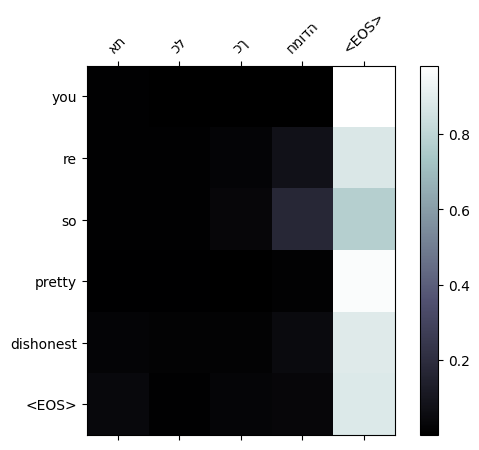

input = אני לא מוכנה להכנע
output = i m not ready to give up without you <EOS>


<ipython-input-62-74bae3114fe3>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-62-74bae3114fe3>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


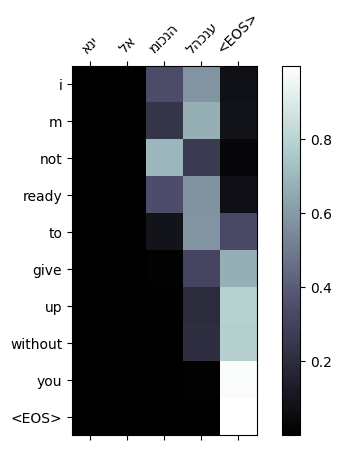

input = 

<ipython-input-62-74bae3114fe3>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +


אני רואה את הים
output = i m watching my job <EOS>


<ipython-input-62-74bae3114fe3>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


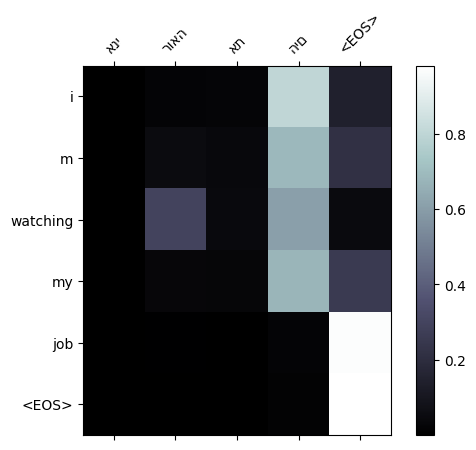

input = אני משוכנע שתום סיפר לך את זה
output = sure sure it to be doing that i trust <EOS>


<ipython-input-62-74bae3114fe3>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-62-74bae3114fe3>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


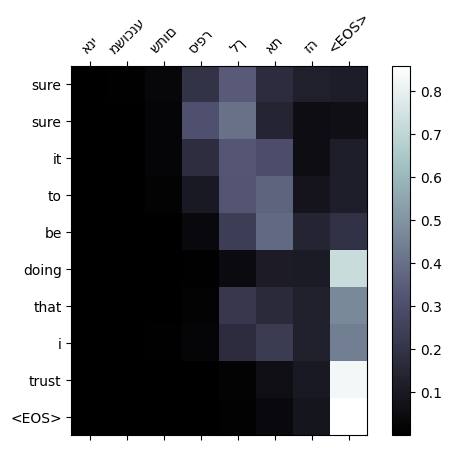

input = זאת רק בדיחה
output = i m just kidding <EOS>


<ipython-input-62-74bae3114fe3>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-62-74bae3114fe3>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


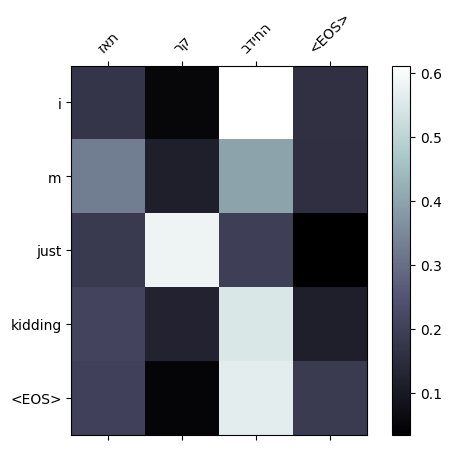

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    ax.tick_params("x", labelrotation=45)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

evaluateAndShowAttention('את כל כך חמודה')

evaluateAndShowAttention('אני לא מוכנה להכנע')

evaluateAndShowAttention('אני רואה את הים')

evaluateAndShowAttention('אני משוכנע שתום סיפר לך את זה')

evaluateAndShowAttention('זאת רק בדיחה')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
%%shell
jupyter nbconvert --to html /content/PS3_Attention_Please_2024_ID_310320650.ipynb  # Add --execute to pre-run the notebook and resolve dependencies

[NbConvertApp] Converting notebook /content/PS3_Attention_Please_2024_ID_310320650.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 670822 bytes to /content/PS3_Attention_Please_2024_ID_310320650.html


In [3]:
!pip install nbconvert

In [16]:
!jupyter nbconvert -- to html '/content/drive/MyDrive/Statistics\ Masters/Adv.\ computational learning and data analysis/Problem\ Set\ 3/PS3_Attention_Please_2024_ID_310320650.ipynb'

[NbConvertApp] WARNING | pattern 'to' matched no files
[NbConvertApp] WARNING | pattern 'html' matched no files
[NbConvertApp] WARNING | pattern '/content/drive/MyDrive/Statistics\\ Masters/Adv.\\ computational learning and data analysis/Problem\\ Set\\ 3/PS3_Attention_Please_2024_ID_310320650.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.

In [14]:
from google.colab import files
files.download('/content/drive/MyDrive/Statistics\ Masters/Adv.\ computational learning and data analysis/Problem\ Set\ 3/PS3_Attention_Please_2024_ID_310320650.ipynb')

FileNotFoundError: Cannot find file: /content/drive/MyDrive/Statistics\ Masters/Adv.\ computational\ learning\ and\ data\ analysis/Problem\ Set\ 3/PS3_Attention_Please_2024_ID_310320650.ipynb